Epoch [1/10], Loss: 1.1087
Epoch [2/10], Loss: 1.0522
Epoch [3/10], Loss: 0.9067
Epoch [4/10], Loss: 0.7284
Epoch [5/10], Loss: 0.5874
Epoch [6/10], Loss: 0.5668
Epoch [7/10], Loss: 0.4100
Epoch [8/10], Loss: 0.3090
Epoch [9/10], Loss: 0.2283
Epoch [10/10], Loss: 0.1945
Test Accuracy: 0.91%


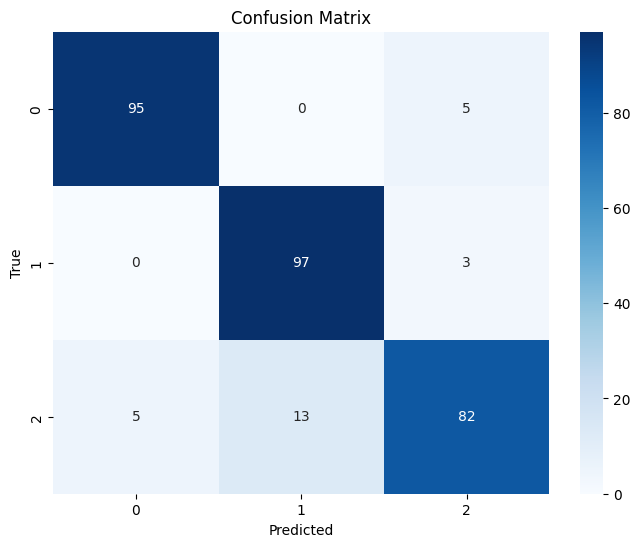

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Hyperparameters
img_size = 28
patch_size = 7
num_classes = 3  # 3 selected classes from MNIST
embed_dim = 64
num_heads = 4
mlp_dim = 128
depth = 2
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# Define transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Select 3 classes (e.g., 0, 1, and 2)
selected_classes = [0, 1, 2]

def sample_class(dataset, classes, num_samples_per_class):
    """Randomly sample `num_samples_per_class` images from each class in `classes`."""
    indices = []
    for target_class in classes:
        class_indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
        sampled_indices = random.sample(class_indices, num_samples_per_class)
        indices.extend(sampled_indices)
    return indices

# Sample 100 images from each of the 3 classes for train and test sets
train_indices = sample_class(train_dataset, selected_classes, 100)
test_indices = sample_class(test_dataset, selected_classes, 100)

# Subset datasets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Define Patch Embedding using Linear layer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.reshape(B, -1, self.patch_size * self.patch_size)
        x = self.proj(x)
        return x

# Define Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mhsa = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # For compatibility with MultiheadAttention
        attn_output, _ = self.mhsa(x, x, x)
        x = x + self.dropout1(attn_output)
        x = x + self.dropout2(self.mlp(self.norm2(x)))
        return x.permute(1, 0, 2)

# Define Vision Transformer (ViT) Model
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, num_classes=3, embed_dim=64, depth=2, num_heads=4, mlp_dim=128):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.1)

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim)
            for _ in range(depth)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        for encoder_block in self.encoder:
            x = encoder_block(x)

        x = self.mlp_head(x[:, 0])
        return x

# Training the Vision Transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = VisionTransformer(embed_dim=embed_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    vit.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Evaluate Model
vit.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Q1-PART1**

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import random

# Configuration
batch_size = 32
selected_classes = [0, 1, 2]
num_samples_per_class = 100

# Function to sample classes
def sample_class(dataset, selected_classes, num_samples_per_class):
    indices = []
    for cls in selected_classes:
        class_indices = [i for i, (_, label) in enumerate(dataset) if label == cls]
        sampled_indices = random.sample(class_indices, num_samples_per_class)
        indices.extend(sampled_indices)
    return indices

# Load MNIST dataset with RGB conversion
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Sample images for ViT
train_indices_vit = sample_class(train_dataset, selected_classes, num_samples_per_class)
test_indices_vit = sample_class(test_dataset, selected_classes, num_samples_per_class)

train_subset_vit = Subset(train_dataset, train_indices_vit)
test_subset_vit = Subset(test_dataset, test_indices_vit)

train_loader_vit = DataLoader(train_subset_vit, batch_size=batch_size, shuffle=True)
test_loader_vit = DataLoader(test_subset_vit, batch_size=batch_size, shuffle=False)

# Sample images for Swin Transformer (different samples)
train_indices_swin = sample_class(train_dataset, selected_classes, num_samples_per_class)
test_indices_swin = sample_class(test_dataset, selected_classes, num_samples_per_class)

train_subset_swin = Subset(train_dataset, train_indices_swin)
test_subset_swin = Subset(test_dataset, test_indices_swin)

train_loader_swin = DataLoader(train_subset_swin, batch_size=batch_size, shuffle=True)
test_loader_swin = DataLoader(test_subset_swin, batch_size=batch_size, shuffle=False)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT Epoch [1/10], Loss: 0.7222
ViT Epoch [2/10], Loss: 0.1959
ViT Epoch [3/10], Loss: 0.0965
ViT Epoch [4/10], Loss: 0.0557
ViT Epoch [5/10], Loss: 0.0403
ViT Epoch [6/10], Loss: 0.0334
ViT Epoch [7/10], Loss: 0.0291
ViT Epoch [8/10], Loss: 0.0262
ViT Epoch [9/10], Loss: 0.0239
ViT Epoch [10/10], Loss: 0.0220
Accuracy of the ViT model on the test set: 99.67%


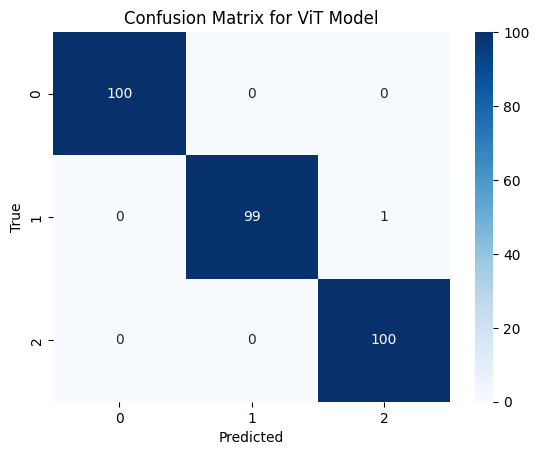

In [ ]:
from transformers import ViTForImageClassification
import torch.optim as optim
import torch.nn as nn

# Configuration
learning_rate = 1e-4
num_epochs = 10
num_classes = 3

# Load ViT Model
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
vit_model.to(device)

# Optimizer for ViT
optimizer_vit = optim.Adam(vit_model.parameters(), lr=learning_rate)

# Train ViT Model
vit_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader_vit:
        images, labels = images.to(device), labels.to(device)

        outputs = vit_model(images).logits
        loss = nn.CrossEntropyLoss()(outputs, labels)

        optimizer_vit.zero_grad()
        loss.backward()
        optimizer_vit.step()
        total_loss += loss.item()

    print(f"ViT Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader_vit):.4f}")

# Evaluate the ViT Model
vit_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_vit:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total * 100
print(f'Accuracy of the ViT model on the test set: {accuracy:.2f}%')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ViT Model')
plt.show()


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swin Transformer Epoch [1/10], Loss: 0.0745
Swin Transformer Epoch [2/10], Loss: 0.0129
Swin Transformer Epoch [3/10], Loss: 0.0067
Swin Transformer Epoch [4/10], Loss: 0.0028
Swin Transformer Epoch [5/10], Loss: 0.0029
Swin Transformer Epoch [6/10], Loss: 0.0014
Swin Transformer Epoch [7/10], Loss: 0.0009
Swin Transformer Epoch [8/10], Loss: 0.0006
Swin Transformer Epoch [9/10], Loss: 0.0007
Swin Transformer Epoch [10/10], Loss: 0.0006
Accuracy of the Swin Transformer on the test set: 100.00%


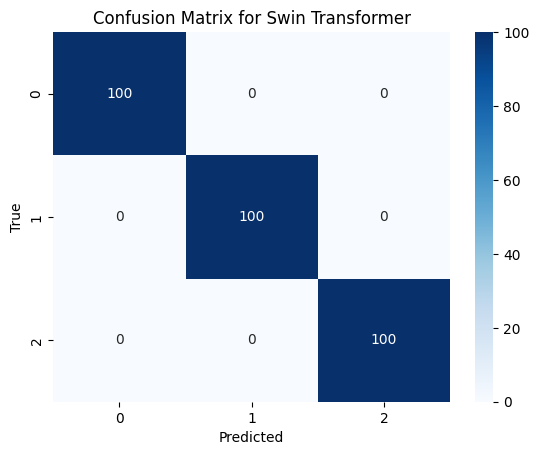

In [ ]:
from transformers import SwinForImageClassification
from torch.nn import KLDivLoss

# Load Swin Transformer model
swin_model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-tiny-patch4-window7-224',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
swin_model.to(device)

# Optimizer for Swin Transformer
optimizer_swin = optim.Adam(swin_model.parameters(), lr=learning_rate)
distillation_criterion = KLDivLoss(reduction='batchmean')

# Train Swin Transformer with KL Distillation Loss
for epoch in range(num_epochs):
    swin_model.train()
    total_loss = 0
    for images, _ in train_loader_swin:
        images = images.to(device)

        with torch.no_grad():
            vit_outputs = vit_model(images).logits  # Get logits from the ViT model

        swin_outputs = swin_model(images).logits  # Get logits directly from the Swin model
        loss = distillation_criterion(
            nn.functional.log_softmax(swin_outputs / temperature, dim=1),
            nn.functional.softmax(vit_outputs / temperature, dim=1)
        )
        optimizer_swin.zero_grad()
        loss.backward()
        optimizer_swin.step()
        total_loss += loss.item()

    print(f'Swin Transformer Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader_swin):.4f}')

# Evaluate the Swin Transformer
swin_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_swin:
        images, labels = images.to(device), labels.to(device)
        outputs = swin_model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total * 100
print(f'Accuracy of the Swin Transformer on the test set: {accuracy:.2f}%')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Swin Transformer')
plt.show()


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Define augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5),
    transforms.Resize((224, 224)),  # Resize to match the input size of ViT
    transforms.Grayscale(num_output_channels=3),  # Ensure the images are RGB
    transforms.ToTensor()
])

# Apply augmentation to datasets
train_dataset_augmented = datasets.MNIST(root="./data", train=True, transform=augmentation_transforms, download=True)
train_subset_augmented = Subset(train_dataset_augmented, train_indices_vit)
train_loader_augmented = DataLoader(train_subset_augmented, batch_size=batch_size, shuffle=True)

# Retrain the ViT model with augmented data
vit_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader_augmented:
        images, labels = images.to(device), labels.to(device)

        outputs = vit_model(images).logits
        loss = nn.CrossEntropyLoss()(outputs, labels)

        optimizer_vit.zero_grad()
        loss.backward()
        optimizer_vit.step()
        total_loss += loss.item()

    print(f"Augmented ViT Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader_augmented):.4f}")


Augmented ViT Epoch [1/10], Loss: 0.0258
Augmented ViT Epoch [2/10], Loss: 0.1512
Augmented ViT Epoch [3/10], Loss: 0.0736
Augmented ViT Epoch [4/10], Loss: 0.0492
Augmented ViT Epoch [5/10], Loss: 0.0699
Augmented ViT Epoch [6/10], Loss: 0.0353
Augmented ViT Epoch [7/10], Loss: 0.0220
Augmented ViT Epoch [8/10], Loss: 0.0164
Augmented ViT Epoch [9/10], Loss: 0.0140
Augmented ViT Epoch [10/10], Loss: 0.0143


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange

# Define the InfoNCE Loss function
def info_nce_loss(features, temperature=0.1):
    b = features.size(0)
    labels = torch.cat([torch.arange(b // 2) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(features.device)
    features = nn.functional.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)

    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(features.device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(labels.shape[0], -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(features.device)
    logits = logits / temperature
    return nn.CrossEntropyLoss()(logits, labels)

# Define Patch Embedding class
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape  # Batch size, Channels, Height, Width
        x = x.view(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5)  # Rearrange to (B, H//p, W//p, C, p, p)
        x = x.reshape(B, -1, self.patch_size * self.patch_size)  # Flatten patches
        x = self.proj(x)  # Apply linear projection
        return x

# Define Multi-Head Self-Attention class
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        q = self.query(x).view(B, N, self.num_heads, self.head_dim)
        k = self.key(x).view(B, N, self.num_heads, self.head_dim)
        v = self.value(x).view(B, N, self.num_heads, self.head_dim)

        q, k, v = map(lambda t: rearrange(t, 'b n h d -> b h n d'), (q, k, v))

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.out(out)
        return out

# Define Transformer Encoder Block class
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.2):  # Increased dropout
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mhsa = MultiHeadSelfAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout1(self.mhsa(self.norm1(x)))
        x = x + self.dropout2(self.mlp(self.norm2(x)))
        return x

# Define Vision Transformer class
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, num_classes=10, embed_dim=128, depth=4, num_heads=8, mlp_dim=256):  # Deeper model
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.1)

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim)
            for _ in range(depth)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        for encoder_block in self.encoder:
            x = encoder_block(x)

        x = self.mlp_head(x[:, 0])
        return x

# Hyperparameters and settings
img_size = 28
patch_size = 7
embed_dim = 128
num_classes = 10
batch_size = 128  # Increased batch size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Updated data augmentation
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
])

# Load MNIST dataset with updated transforms
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize Vision Transformer
vit = VisionTransformer(img_size=img_size, patch_size=patch_size, num_classes=num_classes, embed_dim=embed_dim, depth=4, num_heads=4, mlp_dim=256).to(device)

# Optimizer and Scheduler
optimizer = optim.Adam(vit.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop using InfoNCE Loss
num_epochs = 20
for epoch in range(num_epochs):
    vit.train()
    total_loss = 0.0
    for images, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images1 = transforms.functional.hflip(images)
        images2 = transforms.functional.vflip(images)
        images = torch.cat([images1, images2], dim=0).to(device)

        optimizer.zero_grad()
        features = vit(images)
        loss = info_nce_loss(features)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()  # Adjust the learning rate
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

test_accuracy = evaluate_model(vit, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/20: 100%|██████████| 469/469 [05:22<00:00,  1.46it/s]


Epoch [1/20], Loss: 4.1006


Epoch 2/20: 100%|██████████| 469/469 [05:20<00:00,  1.46it/s]


Epoch [2/20], Loss: 1.5541


Epoch 3/20: 100%|██████████| 469/469 [05:25<00:00,  1.44it/s]


Epoch [3/20], Loss: 1.0901


Epoch 4/20: 100%|██████████| 469/469 [05:20<00:00,  1.46it/s]


Epoch [4/20], Loss: 0.8767


Epoch 5/20: 100%|██████████| 469/469 [05:22<00:00,  1.46it/s]


Epoch [5/20], Loss: 0.7903


Epoch 6/20: 100%|██████████| 469/469 [05:19<00:00,  1.47it/s]


Epoch [6/20], Loss: 0.7007


Epoch 7/20: 100%|██████████| 469/469 [05:23<00:00,  1.45it/s]


Epoch [7/20], Loss: 0.6586


Epoch 8/20: 100%|██████████| 469/469 [05:21<00:00,  1.46it/s]


Epoch [8/20], Loss: 0.6350


Epoch 9/20: 100%|██████████| 469/469 [05:21<00:00,  1.46it/s]


Epoch [9/20], Loss: 0.6174


Epoch 10/20: 100%|██████████| 469/469 [05:20<00:00,  1.46it/s]


Epoch [10/20], Loss: 0.6020


Epoch 11/20: 100%|██████████| 469/469 [05:21<00:00,  1.46it/s]


Epoch [11/20], Loss: 0.5867


Epoch 12/20: 100%|██████████| 469/469 [05:21<00:00,  1.46it/s]


Epoch [12/20], Loss: 0.5852


Epoch 13/20: 100%|██████████| 469/469 [05:21<00:00,  1.46it/s]


Epoch [13/20], Loss: 0.5859


Epoch 14/20: 100%|██████████| 469/469 [05:20<00:00,  1.46it/s]


Epoch [14/20], Loss: 0.5828


Epoch 15/20: 100%|██████████| 469/469 [05:20<00:00,  1.46it/s]


Epoch [15/20], Loss: 0.5810


Epoch 16/20: 100%|██████████| 469/469 [05:20<00:00,  1.47it/s]


Epoch [16/20], Loss: 0.5781


Epoch 17/20: 100%|██████████| 469/469 [05:19<00:00,  1.47it/s]


Epoch [17/20], Loss: 0.5784


Epoch 18/20: 100%|██████████| 469/469 [05:20<00:00,  1.47it/s]


Epoch [18/20], Loss: 0.5779


Epoch 19/20: 100%|██████████| 469/469 [05:25<00:00,  1.44it/s]


Epoch [19/20], Loss: 0.5738


Epoch 20/20: 100%|██████████| 469/469 [05:20<00:00,  1.46it/s]


Epoch [20/20], Loss: 0.5752
Test Accuracy: 9.90%


Epoch 1/5: 100%|██████████| 469/469 [05:33<00:00,  1.41it/s]


Epoch [1/5], Loss: 0.0543


Epoch 2/5: 100%|██████████| 469/469 [05:18<00:00,  1.47it/s]


Epoch [2/5], Loss: 0.0056


Epoch 3/5: 100%|██████████| 469/469 [05:20<00:00,  1.46it/s]


Epoch [3/5], Loss: 0.0024


Epoch 4/5: 100%|██████████| 469/469 [05:17<00:00,  1.48it/s]


Epoch [4/5], Loss: 0.0014


Epoch 5/5: 100%|██████████| 469/469 [05:17<00:00,  1.48it/s]


Epoch [5/5], Loss: 0.0009
Test Accuracy: 9.58%
